In [1]:
import pymongo
import math 
import re
import pandas as pd
# import numpy as np
import pylab 
from matplotlib import pyplot as plt
# from scipy import stats 
from  qgrid import show_grid as show 
from datetime import datetime
import seaborn as sns

class testCase(object): 
    """in general its just the name of the machine where we launched the test """
    def __init__ (self , testname,database='rapls2',serveraddr='172.16.45.8',serverport=27017): 
        self._client = pymongo.MongoClient(serveraddr, serverport)
        self._db=self._client[database]
        self._testname=testname 
        self._sensors=self._db['sensor'+self._testname]
        
    def gettimetamps(self,containername): 
        containerdata=list(self._sensors.find({'target':containername},projection=['timestamp']))
        begintime= containerdata[0]['timestamp']
        endtime=containerdata[-1]['timestamp']
        return begintime , endtime 

    def getpowers(self,containername): 
        #get the power consumption of the system  between begin and end 
        begin , end = self.gettimetamps(containername) 
        x=list(self._sensors.find({'target':'system','timestamp' :{'$gte':begin,'$lte':end}},projection=['rapl','timestamp']))
        conso= pd.DataFrame(x)
        sonde=next(iter(x[0]['rapl']['0']))
        conso['power']=conso['rapl'].apply(lambda row :math.ldexp( row['0'][sonde]['RAPL_ENERGY_PKG'],-32))
        return conso.loc[:,['timestamp','power']]

    def getenergy(self,containername):
        powers =self.getpowers(containername)
        return powers['power'].sum()

    def getrecap(self): 
        meausres = self._db['recap'+self._testname].find(projection={'_id': False,'id':False})
        return pd.DataFrame(list(meausres))
    




# simple example

In [15]:
#getting an instance of our machine 
machine= testCase('testhaxe3110219')


In [25]:
#to print all the meausres done in this machine 
machine.getrecap()
## this only used if you launched the test with tester.sh 

,execution energy,execution time,name,warmup energy,warmup time
0,1281.057373,43,haxetommticppintArithmetic50n0,0.000000,0
1,31258.072266,1003,haxetommtipythonintArithmetic50n0,3047.544067,101
2,793.356506,28,haxetommticsintArithmetic50n0,0.000000,0
3,761.949158,27,haxetommtijavaintArithmetic50n0,0.000000,0
4,806.177734,28,haxetommtijsintArithmetic50n0,0.000000,0
5,6601.046448,212,haxetommtiphpintArithmetic50n0,0.000000,0
6,32910.665955,1053,haxetommtiluaintArithmetic50n0,0.000000,0
7,18052.119690,559,haxetommtiinterpintArithmetic50n0,0.000000,0
8,757.086487,26,haxetommticppintArithmetic50n1,0.000000,0


In [38]:
bench="intArithmetic"
measure='execution energy'

egx = re.compile(bench+".*", re.IGNORECASE)
data=machine.getrecap()
data["implementation"]= data["name"].apply(lambda name:re.search('tommti(?P<name>.*)'+bench+'.*n', name).group(1))
data["loop"]=data["name"].apply(lambda name:re.search('tommti.*'+bench+'(?P<a>.*)n', name).group(1))
mystats=data[data['loop']=='50']
mystats=mystats.sort_values(measure,ascending=True)
# plt.subplots(nrows=1,ncols=1,figsize=(20, 15))
# sns.set_palette(mystats20.get_palette())

# Summary 

In [50]:
show(mystats.groupby('implementation').mean().sort_values(measure,ascending=True))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Barplot

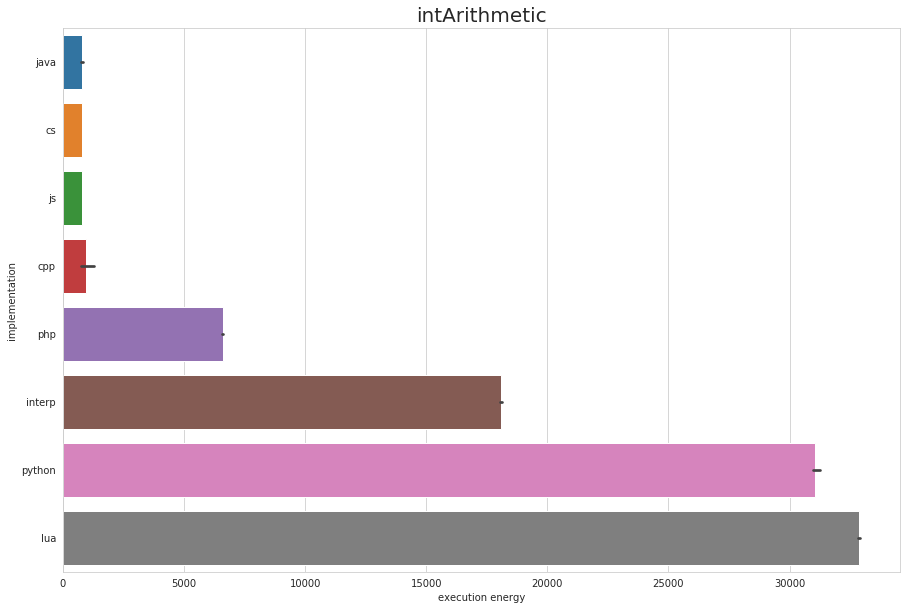

In [65]:
sns.set_style("whitegrid")
plt.subplots(nrows=1,ncols=1,figsize=(15, 10))
ax= sns.barplot(y='implementation',x=measure,data=mystats,orient='h',order=list(mystats.groupby('implementation').mean().sort_values(measure,ascending=True).index))
var=ax.set_title(bench,size=20)

In [64]:
list(mystats.groupby('implementation').mean().sort_values(measure,ascending=True).index)

['java', 'cs', 'js', 'cpp', 'php', 'interp', 'python', 'lua']